In [1]:
import sys
sys.path.insert(0, "./lib/")

import VOC2012DataProvider
import VOC2012_npz_files_writter
import tensorflow as tf
import os.path
import numpy as np
from PIL import Image
from Agent import ObjLocaliser
import time
import matplotlib.pyplot as plt
import cv2 as cv
%matplotlib inline

/home/mohammad/Tensorflow/local/lib/python2.7/site-packages/requests/__init__.py:83: RequestsDependencyWarning: Old version of cryptography ([1, 2, 3]) may cause slowdown.
  warnings.warn(warning, RequestsDependencyWarning)


#This cell reads VOC 2012 dataset and save them in .npz files for future.
#The process of reading data and put them in prper format is time consuming so they are stored in a file.

xml_path = "../VOC2012/Annotations/*.xml"
destination = "../data/"

#It splits dataset to 80% for training and 20% validation.
if not (os.path.isfile(destination+"test_input.npz") or os.path.isfile(destination+"test_target.npz")):
    VOC2012_npz_files_writter.writting_files(xml_path, destination, percentage=0)
    print("Files are ready!!!")
else:
    print("Records have already prepared!!!")

inputs = VOC2012DataProvider.PascalDataProvider('train', batch_size=50)

In [2]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial, name = "W")

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial, name = "B")

def conv2d(x, W, stride):
    return tf.nn.conv2d(x, W, strides=[1, stride, stride, 1], padding='SAME')

def max_pool(x, kernel_size, stride, name = "pool"):
    return tf.nn.max_pool(x, ksize=[1, kernel_size, kernel_size, 1],
    strides=[1, stride, stride, 1], padding='SAME', name = name)

tf.reset_default_graph()

x = tf.placeholder(tf.float32, shape=[None, 224*224*3], name = 'x')

x_image = tf.reshape(x, [-1, 224, 224, 3])
tf.summary.image('input', x_image, 1)


#First Conv layer weights and biases
W_conv1 = weight_variable([7, 7, 3, 96]) #[filter_size, filter_size, num_input_channels, num_filters]
b_conv1 = bias_variable([96])
#Second conv layer weights and biases
W_conv2 = weight_variable([5, 5, 96, 256])
b_conv2 = bias_variable([256])
#Third conv layer weights and biases
W_conv3 = weight_variable([3, 3, 256, 384])
b_conv3 = bias_variable([384])
#Fourth conv layer weights and biases
W_conv4 = weight_variable([3, 3, 384, 384])
b_conv4 = bias_variable([384])
#First fully-connected layer weights and biases
W_fc1 = weight_variable([7*7*384, 4096])
b_fc1 = bias_variable([4096])
#Second fully-connected layer weights and biases
W_fc2 = weight_variable([4096, 4096])
b_fc2 = bias_variable([4096])
#Output layer weights and biases
W_fc3 = weight_variable([4096, 11])
b_fc3 = bias_variable([11])



with tf.name_scope("conv1"):
    #First conv layer
    h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1, 2) + b_conv1, name = "hconv1") #output shape = (112,112,96)
    #First conv layer pooling layer
    h_pool1 = max_pool(h_conv1, 3, 2, name = "pool1") #output shape = (56,56,96)
    tf.summary.histogram("weights", W_conv1)
    tf.summary.histogram("biases", b_conv1)
    tf.summary.histogram("activations", h_conv1)

with tf.name_scope("conv2"):    
    #Second conv layer
    h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2, 2) + b_conv2, name = "hconv2") #output shape = (28, 28, 256)
    #Second conv layer pooling layer
    h_pool2 = max_pool(h_conv2, 3, 2, name = "pool2") #output shape = (14, 14, 256)
    tf.summary.histogram("weights", W_conv2)
    tf.summary.histogram("biases", b_conv2)
    tf.summary.histogram("activations", h_conv2)

with tf.name_scope("conv3"):
    #Third conv layer
    h_conv3 = tf.nn.relu(conv2d(h_pool2, W_conv3, 1) + b_conv3, name = "hconv3") #output shape = (14, 14, 384)
    tf.summary.histogram("weights", W_conv3)
    tf.summary.histogram("biases", b_conv3)
    tf.summary.histogram("activations", h_conv3)

with tf.name_scope("conv4"):    
    #Fourth conv layer
    h_conv4 = tf.nn.relu(conv2d(h_conv3, W_conv4, 1) + b_conv4, name = "hconv4") #output shape = (14, 14, 384)
    #Fourth conv layer pooling layer
    h_pool4 = max_pool(h_conv4, 3, 2, name = "pool4") #output shape = (7, 7, 384)
    tf.summary.histogram("weights", W_conv4)
    tf.summary.histogram("biases", b_conv4)
    tf.summary.histogram("activations", h_conv4)

with tf.name_scope("fc1"):    
    #First fully-connected layer
    h_flat1 = tf.reshape(h_pool4, [-1, 7*7*384])
    h_fc1 = tf.nn.relu(tf.matmul(h_flat1, W_fc1) + b_fc1, name = "hfc1") #(input, output) = (7*7*384, 4096)
    tf.summary.histogram("weights", W_fc1)
    tf.summary.histogram("biases", b_fc1)
    tf.summary.histogram("activations", h_fc1)

with tf.name_scope("fc2"):    
    #Second fully-connected layer
    h_fc2 = tf.nn.relu(tf.matmul(h_fc1, W_fc2) + b_fc2, name = "hfc2") #(input, output) = (4096, 4096)
    tf.summary.histogram("weights", W_fc2)
    tf.summary.histogram("biases", b_fc2)
    tf.summary.histogram("activations", h_fc2)

with tf.name_scope("output"):
    #Output layer
    h_fc3 = tf.nn.relu(tf.matmul(h_fc2, W_fc3) + b_fc3, name = "hfc3") #(input, output) = (4096, 10)
    tf.summary.histogram("weights", W_fc3)
    tf.summary.histogram("biases", b_fc3)
    tf.summary.histogram("activations", h_fc3)
    Qout = tf.nn.softmax(h_fc3)

tf.reset_default_graph()

x = tf.placeholder(tf.float32, shape=[None, 224*224*6], name = 'x')

x_image = tf.reshape(x, [-1, 224, 224, 6])
tf.summary.image('input', x_image[:,:,:,0:3], 1)


#First Conv layer weights and biases
W_conv1 = weight_variable([7, 7, 6, 16]) #[filter_size, filter_size, num_input_channels, num_filters]
b_conv1 = bias_variable([16])


#First fully-connected layer weights and biases
W_fc1 = weight_variable([56*56*16, 2048])
b_fc1 = bias_variable([2048])

#Second fully-connected layer weights and biases 
W_fc2 = weight_variable([2048, 1024]) 
b_fc2 = bias_variable([1024])

#Output layer weights and biases
W_fc3 = weight_variable([1024, 11])
b_fc3 = bias_variable([11])



with tf.name_scope("conv1"):
    #First conv layer
    h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1, 2) + b_conv1, name = "hconv1") #output shape = (112,112,16)
    #First conv layer pooling layer
    h_pool1 = max_pool(h_conv1, 3, 2, name = "pool1") #output shape = (56,56,16)
    tf.summary.histogram("weights", W_conv1)
    tf.summary.histogram("biases", b_conv1)
    tf.summary.histogram("activations", h_conv1)


with tf.name_scope("fc1"):    
    #First fully-connected layer
    h_flat1 = tf.reshape(h_pool1, [-1, 56*56*16])
    h_fc1 = tf.nn.relu(tf.matmul(h_flat1, W_fc1) + b_fc1, name = "hfc1") #(input, output) = (7*7*70, 2048)
    tf.summary.histogram("weights", W_fc1)
    tf.summary.histogram("biases", b_fc1)
    tf.summary.histogram("activations", h_fc1)
    
with tf.name_scope("fc2"):

    #Second fully-connected layer
    h_fc2 = tf.nn.relu(tf.matmul(h_fc1, W_fc2) + b_fc2, name = "hfc2") #(input, output) = (2048, 1024)
    tf.summary.histogram("weights", W_fc2)
    tf.summary.histogram("biases", b_fc2)
    tf.summary.histogram("activations", h_fc2)


with tf.name_scope("output"):
    #Output layer
    h_fc3 = tf.nn.relu(tf.matmul(h_fc2, W_fc3) + b_fc3, name = "hfc3") #(input, output) = (1024, 10)
    tf.summary.histogram("weights", W_fc3)
    tf.summary.histogram("biases", b_fc3)
    tf.summary.histogram("activations", h_fc3)
    Qout = tf.nn.softmax(h_fc3)

In [3]:
tf.reset_default_graph()

x = tf.placeholder(tf.float32, shape=[None, 224*224*3], name = 'x')

x_image = tf.reshape(x, [-1, 224, 224, 3])
tf.summary.image('input', x_image, 1)


#First Conv layer weights and biases
W_conv1 = weight_variable([7, 7, 3, 16]) #[filter_size, filter_size, num_input_channels, num_filters]
b_conv1 = bias_variable([16])
#Second conv layer weights and biases
W_conv2 = weight_variable([5, 5, 16, 36])
b_conv2 = bias_variable([36])

#First fully-connected layer weights and biases
W_fc1 = weight_variable([14*14*36, 2048])
b_fc1 = bias_variable([2048])

#Second fully-connected layer weights and biases 
W_fc2 = weight_variable([2048, 1024]) 
b_fc2 = bias_variable([1024])

#Output layer weights and biases
W_fc3 = weight_variable([1024, 11])
b_fc3 = bias_variable([11])



with tf.name_scope("conv1"):
    #First conv layer
    h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1, 2) + b_conv1, name = "hconv1") #output shape = (112,112,16)
    #First conv layer pooling layer
    h_pool1 = max_pool(h_conv1, 3, 2, name = "pool1") #output shape = (56,56,16)
    tf.summary.histogram("weights", W_conv1)
    tf.summary.histogram("biases", b_conv1)
    tf.summary.histogram("activations", h_conv1)

with tf.name_scope("conv2"):    
    #Second conv layer
    h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2, 2) + b_conv2, name = "hconv2") #output shape = (28, 28, 36)
    #Second conv layer pooling layer
    h_pool2 = max_pool(h_conv2, 3, 2, name = "pool2") #output shape = (14, 14, 36)
    tf.summary.histogram("weights", W_conv2)
    tf.summary.histogram("biases", b_conv2)
    tf.summary.histogram("activations", h_conv2)


with tf.name_scope("fc1"):    
    #First fully-connected layer
    h_flat1 = tf.reshape(h_pool2, [-1, 14*14*36])
    h_fc1 = tf.nn.relu(tf.matmul(h_flat1, W_fc1) + b_fc1, name = "hfc1") #(input, output) = (7*7*70, 2048)
    tf.summary.histogram("weights", W_fc1)
    tf.summary.histogram("biases", b_fc1)
    tf.summary.histogram("activations", h_fc1)
    
with tf.name_scope("fc2"):

    #Second fully-connected layer
    h_fc2 = tf.nn.relu(tf.matmul(h_fc1, W_fc2) + b_fc2, name = "hfc2") #(input, output) = (2048, 1024)
    tf.summary.histogram("weights", W_fc2)
    tf.summary.histogram("biases", b_fc2)
    tf.summary.histogram("activations", h_fc2)


with tf.name_scope("output"):
    #Output layer
    h_fc3 = tf.nn.relu(tf.matmul(h_fc2, W_fc3) + b_fc3, name = "hfc3") #(input, output) = (1024, 10)
    tf.summary.histogram("weights", W_fc3)
    tf.summary.histogram("biases", b_fc3)
    tf.summary.histogram("activations", h_fc3)
    Qout = tf.nn.softmax(h_fc3)

In [4]:
predict = tf.argmax(Qout,1)

with tf.name_scope("loss"):
    #Below we obtain the loss by taking the sum of squares difference between the target and prediction Q values.
    nextQ = tf.placeholder(shape=[1,11],dtype=tf.float32, name = 'nextQ')
    loss = tf.reduce_sum(tf.square(nextQ - Qout))
    tf.summary.scalar("loss", loss)
        
with tf.name_scope("train"):
    trainer = tf.train.AdamOptimizer(learning_rate=1e-3)
    updateModel = trainer.minimize(loss)
    
summ = tf.summary.merge_all()

saver = tf.train.Saver()

sess = tf.Session()
sess.run(tf.global_variables_initializer())

writer = tf.summary.FileWriter("../report/test")
writer.add_graph(sess.graph)

In [5]:
actions = {
            0: 'MOVE_RIGHT',
            1: 'MOVE_DOWN',
            2: 'SCALE_UP',
            3: 'ASPECT_RATIO_UP',
            4: 'MOVE_LEFT',
            5: 'MOVE_UP',
            6: 'SCALE_DOWN',
            7: 'ASPECT_RATIO_DOWN',
            8: 'SPLIT_HORIZONTAL',
            9: 'SPLIT_VERTICAL',
            10: 'PLACE_LANDMARK',
            11: 'SKIP_REGION'
        }

#PILimage = Image.frombytes("RGB",(inputs.inputs[0]['image_width'],inputs.inputs[0]['image_height']),inputs.inputs[0]['image'])

#fake_input = np.zeros((224,224,3))
#fake_input[87:137,87:137,:] = 1
#fake_input = fake_input/1.0
#print fake_input.dtype
im2 = (Image.open('../VOC2012/JPEGImages/2010_000959.jpg'))#train
im2 = (Image.open('../VOC2012/JPEGImages/2009_002749.jpg'))#bottle
dqn_agent = ObjLocaliser(np.array(im2),{'xmin':[16], 'xmax':[93], 'ymin':[37], 'ymax':[432]})
e = 0.2
y = .9
iList = []
rList = []
eList = []
num_located = 0

In [16]:

#f = open('../report/actions.txt', 'w')
  # python will convert \n to os.linesep


#for input_batch, target_batch in inputs:
    
#first_obj = [target_batch[i]['xmax'][0], target_batch[i]['xmin'][0], target_batch[i]['ymax'][0], target_batch[i]['ymin'][0]]
#PILimage = Image.frombytes("RGB",(inputs.inputs[0]['image_width'],inputs.inputs[0]['image_height']),inputs.inputs[0]['image'])
#ObjLocaliser object should be initialised with a PIL image object and a dictionary of bounding boxes
#dqn_agent = ObjLocaliser(PILimage, inputs.targets[0])


#dqn_agent = ObjLocaliser(x, {'xmin':[87], 'ymin':[137],'xmax':[87], 'ymax':[137]})




#agent = ObjLocaliser(im2,{'xmin':[170], 'xmax':[220], 'ymin':[58], 'ymax':[206]})
#saver.restore(sess, "/home/mohammad/active localization/models/checkpoint")

for i in range(80):
    #rAll = 0

    #dqn_agent = ObjLocaliser(PILimage, inputs.targets[0])
    #dqn_agent = ObjLocaliser(fake_input, {'xmin':[87], 'ymin':[137],'xmax':[87], 'ymax':[137]})
    dqn_agent = ObjLocaliser(np.array(im2),{'xmin':[16], 'xmax':[93], 'ymin':[37], 'ymax':[432]})


    a = [0,0]
    cumulative_reward = 0
    number_of_actions = 0
    error = 0.
    #j = 0
    while a[0]!=10:
        
        s = np.array(dqn_agent.wrapping(), dtype = 'float').reshape((1,224*224*3))

        a,allQ = sess.run([predict,Qout],feed_dict={x: s})

        if np.random.rand(1) < e:
            a[0] = np.random.randint(11, size=1)

        #Get new state and reward from environment
        r = dqn_agent.takingActions(a[0])
        if r == 3:
            num_located = num_located + 1
        cumulative_reward = cumulative_reward + r
        #f.write("Action:{0}\n".format(actions[a[0]]))
        number_of_actions = number_of_actions + 1
        #print "Action:{0}".format(actions[a[0]])
        #print "Reward:{0}".format(r)
        #dqn_agent.drawActions()
        #time.sleep(1)
        s1 = np.array(dqn_agent.wrapping(), dtype = 'float').reshape((1,224*224*3))

        #Obtain the Q' values by feeding the new state through our network
        Q1 = sess.run(Qout,feed_dict={x:s1})

        #Obtain maxQ' and set our target value for chosen action.
        maxQ1 = np.max(Q1)
        targetQ = allQ
        targetQ[0,a[0]] = r + y*maxQ1

        #Train our network using target and predicted Q values
        _, s, l = sess.run([updateModel,summ, loss],feed_dict={x:s, nextQ:targetQ})
        writer.add_summary(s, i)
        error = error + l
        #print l
        #print("Q:{0}  targetQ:{1}  reward:{2}".format(allQ, targetQ, r))
        #print targetQ-allQ
        #writer.add_summary(repo, j)

        #rAll += r
        #j = j + 1
        
    print("episode:{0} cumulative reward:{1} num of actions:{2}".format(i, cumulative_reward, number_of_actions))
    iList.append(i)
    rList.append(float(cumulative_reward)/number_of_actions)
    eList.append(float(error)/number_of_actions)
    
    #f.write("episode{0} finished***************************\n".format(i))
        
#f.close()
#saver.save(sess, '../models/single_object_bottle_image.ckpt')

episode:0 cumulative reward:-24 num of actions:32
episode:1 cumulative reward:-17 num of actions:31
episode:2 cumulative reward:-9 num of actions:11
episode:3 cumulative reward:-6 num of actions:6
episode:4 cumulative reward:-26 num of actions:34
episode:5 cumulative reward:-29 num of actions:61
episode:6 cumulative reward:-48 num of actions:54
episode:7 cumulative reward:-32 num of actions:38
episode:8 cumulative reward:-20 num of actions:22
episode:9 cumulative reward:-26 num of actions:30
episode:10 cumulative reward:-16 num of actions:34
episode:11 cumulative reward:-18 num of actions:36
episode:12 cumulative reward:-108 num of actions:142
episode:13 cumulative reward:-13 num of actions:25
episode:14 cumulative reward:-9 num of actions:33
episode:15 cumulative reward:-71 num of actions:77
episode:16 cumulative reward:-3 num of actions:7
episode:17 cumulative reward:-76 num of actions:84
episode:18 cumulative reward:-41 num of actions:53
episode:19 cumulative reward:-12 num of actio

23


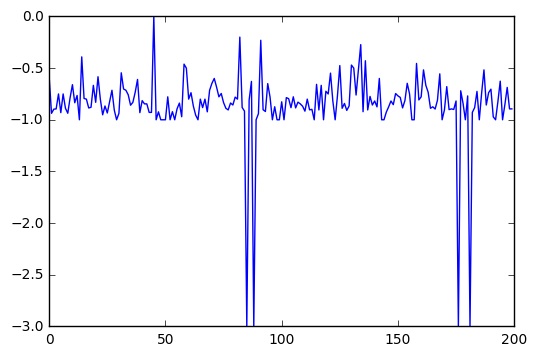

In [17]:
print num_located
plt.plot(rList)

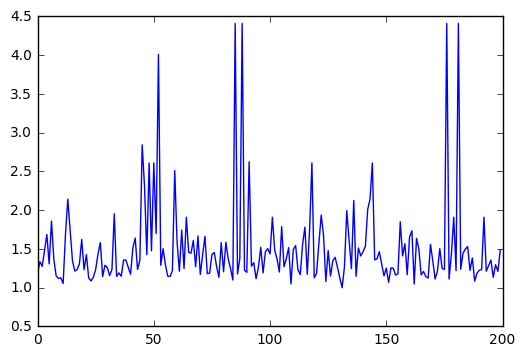

In [18]:
plt.plot(eList)
#plt.savefig("./report/test/error_single_object_bottle_image")

e = 0.1
y = .99
jList = []
rList = []

for input_batch, target_batch in inputs:
    for i in range(len(input_batch)):
        rAll = 0
        #first_obj = [target_batch[i]['xmax'][0], target_batch[i]['xmin'][0], target_batch[i]['ymax'][0], target_batch[i]['ymin'][0]]
        PILimage = Image.frombytes("RGB",(inputs.inputs[i]['image_width'],inputs.inputs[i]['image_height']),inputs.inputs[i]['image'])
        #ObjLocaliser object should be initialised with a PIL image object and a dictionary of bounding boxes
        dqn_agent = ObjLocaliser(PILimage, target_batch[i])

        for j in range(50):
            
            s = np.array(dqn_agent.wrapping(), dtype = 'float').reshape((1,224*224*3))
            
            a,allQ = sess.run([predict,Qout],feed_dict={x: s})
            
            if np.random.rand(1) < e:
                a[0] = np.random.randint(11, size=1)
                
            #Get new state and reward from environment
            r = dqn_agent.takingActions(a[0])
            print "Action:{0}".format(actions[a[0]])
            print "Reward:{0}".format(r)
            #dqn_agent.drawActions()
            #time.sleep(1)
            s1 = np.array(dqn_agent.wrapping(), dtype = 'float').reshape((1,224*224*3))
            
            #Obtain the Q' values by feeding the new state through our network
            Q1 = sess.run(Qout,feed_dict={x:s1})
            
            #Obtain maxQ' and set our target value for chosen action.
            maxQ1 = np.max(Q1)
            targetQ = allQ
            targetQ[0,a[0]] = r + y*maxQ1
            
            #Train our network using target and predicted Q values
            _ = sess.run(updateModel,feed_dict={x:s, nextQ:targetQ})
            #writer.add_summary(repo, j)
            
            rAll += r
            jList.append(j)
            rList.append(rAll)
            
            
        print "Overall reward in episode:{0}".format(rAll)
        

restoring saved models: http://cv-tricks.com/tensorflow-tutorial/save-restore-tensorflow-models-quick-complete-tutorial/

a=sess.graph.get_operation_by_name('fc3')
a.outputs

how to add dropout layer: https://stackoverflow.com/questions/40955223/tensorflow-python-framework-errors-invalidargumenterror-input-to-reshape-is-a-t